# Topic Modeling

Game reviews are a great source of information for players. From the company's point of view, online reviews can be used to gauge feedback on the game. However, since these reviews can be overwhelming in terms of numbers and information, we can use topic modeling to find key insights. This enables people wanting to play the game to quickly extract key information without having the tedious task of going through every review. As well, this serves as another avenue of information that the company can use to inform product decisions.

### Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 500)
import numpy as np
import re
import pprint as pp
from datetime import datetime
import pickle
from pprint import pprint
import warnings
warnings.simplefilter("ignore")
from IPython.display import display, HTML

# Natural language processing libraries
import nltk
from nltk import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy

# Library for unsupervised topic modeling
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

# Libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gthorani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('game_reviews.csv')

In [14]:
df.head(1)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOEG_RTpX1xcPi63E1XUWl_oInN9kAGs79n7WFowsa5at9eD8FCoNyHwF5MZGmjI-ejwkD338fCW65ixrg,ahmed gamal,https://lh3.googleusercontent.com/-_pEzLxFt3No/AAAAAAAAAAI/AAAAAAAAAAA/AMZuucm54H8j-gkfIXvvHKTqUrixcUpAZQ/photo.jpg,They have the antention to make you loose in order to buy very very bad ecperince not recommend at all,1,0,NaN,2020-06-22 00:40:06,NaN,NaN


## Data Preprocessing

In [42]:
clean_df = df[['at','content','score','thumbsUpCount','reviewCreatedVersion']]

In [43]:
clean_df.columns = ['date','review','rating','thumbs_up','version']

In [44]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196843 entries, 0 to 196842
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       196843 non-null  object
 1   review     196843 non-null  object
 2   rating     196843 non-null  int64 
 3   thumbs_up  196843 non-null  int64 
 4   version    168522 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.5+ MB


There are 253(.001%) reviews with no text and 28372(14%) of the reviews do not have an associated version number.

In [45]:
# Drop the null reviews
clean_df = clean_df[~clean_df['review'].isna()]

In [46]:
clean_df.shape

(196843, 5)

In [47]:
# Function to plot the most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([str(text) for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns = 'count', n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x = 'word', y = 'count', palette = 'Blues_r')
    ax.set(ylabel = 'Count')
    plt.show()

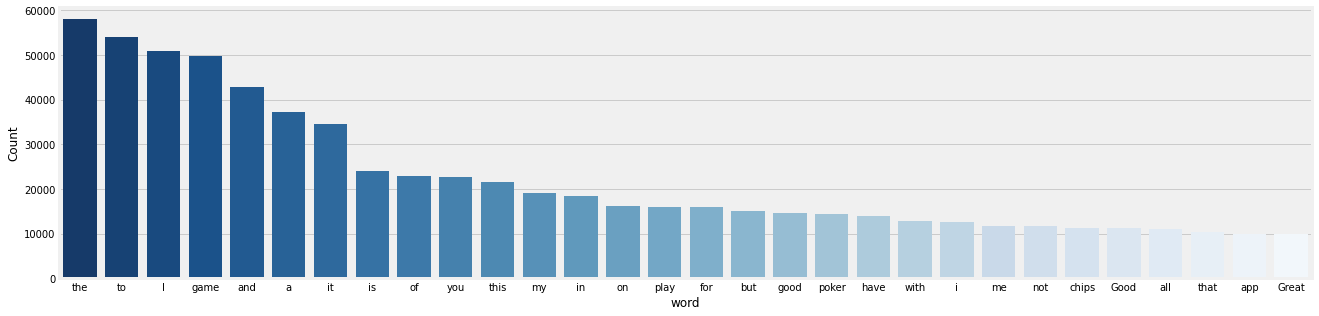

In [48]:
freq_words(clean_df['review'])

Common words such as: to, I, the, it are not important for our task. Thus, we will get rid of any unnecessary words.

In [49]:
# remove unwanted characters, numbers and symbols
clean_df['review'] = clean_df['review'].str.replace('[^a-zA-Z#]', ' ')

In [50]:
#emoji removal
clean_df['review'] = clean_df['review'].str.replace(r'[^\x00-\x7F]+', '')

In [51]:
stop_words = stopwords.words('english')

In [52]:
# Function to remove stopwords
def remove_stopwords(review):
    clean_review = ' '.join([i for i in review if i not in stop_words])
    return clean_review

In [53]:
# Remove short words (length < 3)
clean_df['review'] = clean_df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [54]:
# Remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in clean_df['review']]

In [55]:
# Makes entire text lowercase
reviews = [r.lower() for r in reviews]

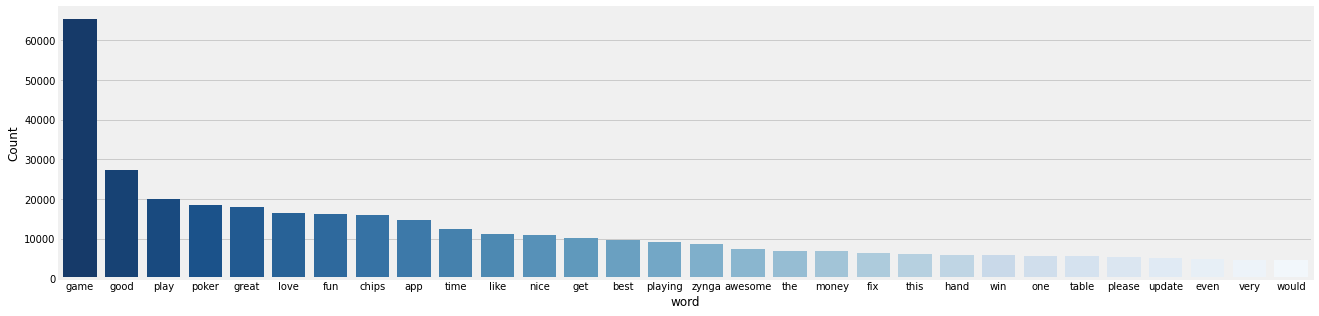

In [56]:
freq_words(reviews)

We can see some improvement as the most frequent words are **game, play, poker, chips, table** which are all relevant with Zynga Poker. There are still redundant words such as, **this, get** and **the**. 

In [ ]:
!python -m spacy download en

### Tokenization & Lemmatization

In [21]:
token_reviews = pd.Series(reviews).apply(lambda x: x.split())
pp.pprint(token_reviews[12])

['daily',
 'friend',
 'bonus',
 'work',
 'first',
 'month',
 'seport',
 'see',
 'problem',
 'numerous',
 'screenshots',
 'proof',
 'very',
 'bad']


In [22]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatize(texts, tags=['NOUN', 'ADJ']): # Filters nouns and adjectives
    output = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [27]:
lem_reviews = lemmatize(token_reviews)
print(lem_reviews[0]) # print lemmatized review

['antention', 'loose', 'order', 'bad', 'ecperince', 'recommend']


In [28]:
len(lem_reviews)

196843

In [29]:
# Save the lemmatized reviews because it takes so long!
with open('lem_reviews.txt', 'wb') as fp:   #Pickling
    pickle.dump(lem_reviews, fp)

In [58]:
with open('lem_reviews.txt', 'rb') as fp:   # Unpickling
    texts = pickle.load(fp)                 # This will be used to create our corpus

Removed further noise from the text (i.e., **this** is removed).

In [59]:
reviews_clean = []
for i in range(len(texts)):
    reviews_clean.append(' '.join(texts[i]))

clean_df['clean_review'] = reviews_clean

In [60]:
32013/196843

0.1626321484634963

In [61]:
clean_df[clean_df['clean_review']==''].shape

(32013, 6)

32013 (16%) reviews were removed from the original data set as these reviews did not give helpful information and are now empty after pre-processing.

In [62]:
clean_df.shape

(196843, 6)

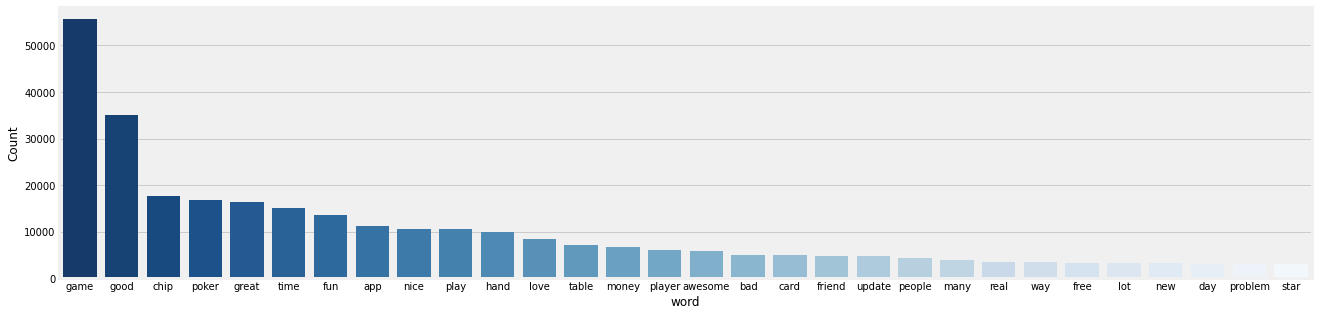

In [35]:
freq_words(clean_df['clean_review'])

We now have more relevant terms we can use to build our topic model.

## LDA Model

In [13]:
# Creates a dictionary to hold all unique terms and assigns an index
id2word = corpora.Dictionary(texts)

In [14]:
# Converts the list of review into a Document Term Matrix
corpus = [id2word.doc2bow(review) for review in texts]

In [38]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

In [72]:
# Creates object for LDA model using the gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model =LDA(corpus=corpus,
               id2word=id2word,
               num_topics=5, 
               random_state=100,
               update_every=1,
               chunksize=100,
               passes=10,
               alpha='auto',
               per_word_topics=True)

The model is built with 5 different topics where each topic is a combination of keywords and each keyword has a certain weight associated to the topic.

In [ ]:
# Save the LDA model!
with open('lda_model.pkl', 'wb') as fp:   #Pickling
    pickle.dump(lda_model, fp)

In [3]:
with open('lda_model.pkl', 'rb') as fp:   # Unpickling
    lda_model = pickle.load(fp)                 # This will be used to create our corpus

In [4]:
lda_model.print_topics()

[(0,
  '0.119*"amazing" + 0.052*"hand" + 0.046*"new" + 0.043*"card" + 0.028*"win" + 0.025*"update" + 0.022*"tournament" + 0.020*"different" + 0.019*"site" + 0.019*"version"'),
 (1,
  '0.096*"year" + 0.060*"playing" + 0.044*"fantastic" + 0.033*"hour" + 0.032*"enjoy" + 0.024*"able" + 0.024*"account" + 0.023*"interesting" + 0.022*"use" + 0.019*"long"'),
 (2,
  '0.174*"poker" + 0.130*"fun" + 0.090*"time" + 0.075*"play" + 0.056*"app" + 0.040*"addictive" + 0.025*"real" + 0.024*"player" + 0.023*"way" + 0.021*"lot"'),
 (3,
  '0.368*"great" + 0.194*"awesome" + 0.031*"excellent" + 0.030*"thank" + 0.026*"table" + 0.024*"graphic" + 0.019*"job" + 0.014*"work" + 0.013*"favorite" + 0.011*"phone"'),
 (4,
  '0.310*"game" + 0.238*"good" + 0.084*"love" + 0.074*"nice" + 0.040*"chip" + 0.018*"cool" + 0.014*"money" + 0.012*"free" + 0.011*"well" + 0.010*"people"')]

**Topic 3** seems to be about a positive experience and time consuming because it has terms: **fun, time, addictive**.  

In [77]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. Lower means better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.55033709643975

Coherence Score:  0.3674213932813827


## Visualization

In [79]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.428203  0.049261       1        1  41.156761
2     -0.048574 -0.397857       2        1  27.261797
3     -0.093913  0.191666       3        1  14.693078
0     -0.144776  0.078663       4        1  10.207417
1     -0.140939  0.078266       5        1   6.680947, topic_info=          Term          Freq         Total Category  logprob  loglift
42        game  79035.000000  79035.000000  Default  30.0000  30.0000
181      great  33552.000000  33552.000000  Default  29.0000  29.0000
103       good  60653.000000  60653.000000  Default  28.0000  28.0000
9        poker  29410.000000  29410.000000  Default  27.0000  27.0000
528    awesome  17670.000000  17670.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
518       seat    304.379913    305.906342   Topic5  -4.9139   2.7009
587        buy    285.008453    286.454803   Topic5  -4.9796   2.7008
227      small    271.492920    272.939789   Topic5  -5.0282   2.7006
1995  beginner    257.333923    258.776550   Topic5  -5.0818   2.7003
1836     class    223.038132    224.472687   Topic5  -5.2248   2.6995

[181 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
187       5  0.998792       able
111       5  0.998576    account
365       5  0.997474     action
8435      4  0.997831  addicting
1153      2  0.999856  addictive
...     ...       ...        ...
145       4  0.999072        win
846       4  0.998299  wonderful
63        3  0.999084       work
171       2  0.997794      world
283       5  0.999698       year

[151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

- Topic 1 is the most prevalent as it has the largest bubble
- This model may not be the best to describe the topics from the reviews as there are overlapping bubbles (Topics 3-5) in top left quadrant
    - This may indicate that there are only 3 definitive topics

## LDA Mallet Model 

Let's see if Mallet's version gives better quality topics.

In [82]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [83]:
ldamallet.show_topics(formatted=False)

[(0,
  [('great', 0.12863114922140317),
   ('fun', 0.12103682179179777),
   ('game', 0.11138346896754583),
   ('nice', 0.09415361577338242),
   ('love', 0.06315235896567399),
   ('awesome', 0.051653905463102445),
   ('update', 0.04298995445186248),
   ('lot', 0.027409104279385678),
   ('cool', 0.020625908065853158),
   ('version', 0.020242626282434107)]),
 (1,
  [('table', 0.061680182528220946),
   ('time', 0.0528272219990942),
   ('app', 0.043760628252565735),
   ('problem', 0.0253625355699307),
   ('star', 0.024132008237696862),
   ('fix', 0.022431487827179273),
   ('connection', 0.021329140425386462),
   ('account', 0.02038915426881895),
   ('tournament', 0.020149885065329037),
   ('thing', 0.016313032480794375)]),
 (2,
  [('chip', 0.14237551238206117),
   ('hand', 0.0796284168910233),
   ('money', 0.05354645193108411),
   ('player', 0.04903506431557075),
   ('card', 0.04099056489364283),
   ('people', 0.03498346633033383),
   ('win', 0.02132802962316169),
   ('bad', 0.0210288874336

In [85]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5235269043821272


By using a different LDA algorithm, the coherence score increased from 0.37 to 0.52.

### Find optimal # of topics

In [86]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [87]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

In [88]:
# Save the LDA model list!
with open('lda_model_list.pkl', 'wb') as fp:   #Pickling
    pickle.dump(model_list, fp)

In [5]:
with open('lda_model_list.pkl', 'rb') as fp:   # Unpickling
    model_list = pickle.load(fp)                 # This will be used to create our corpus

In [89]:
# Save the coherence values
with open('coherence_values.pkl', 'wb') as fp:   #Pickling
    pickle.dump(coherence_values, fp)

In [6]:
with open('coherence_values.pkl', 'rb') as fp:   # Unpickling
    coherence_values = pickle.load(fp)                 # This will be used to create our corpus

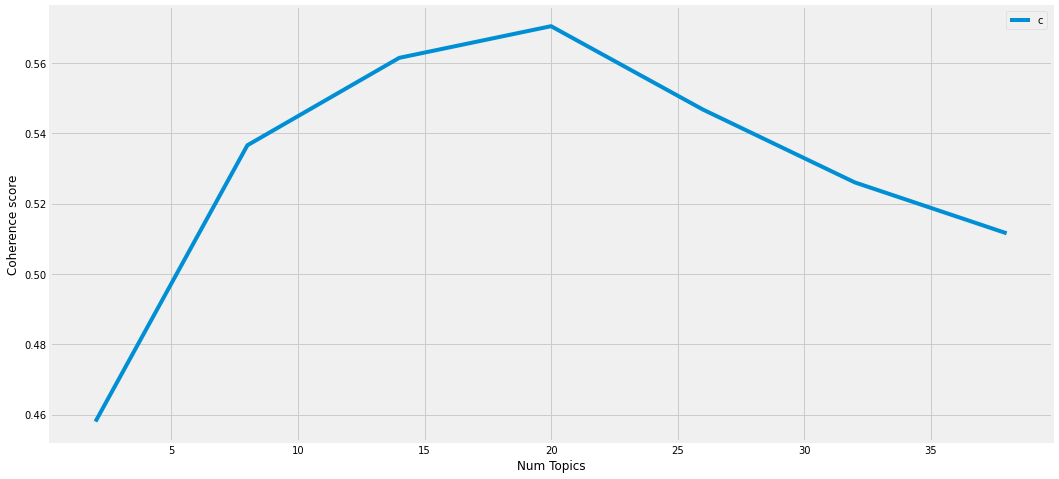

In [43]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [44]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.458
Num Topics = 8  has Coherence Value of 0.5366
Num Topics = 14  has Coherence Value of 0.5615
Num Topics = 20  has Coherence Value of 0.5705
Num Topics = 26  has Coherence Value of 0.5468
Num Topics = 32  has Coherence Value of 0.5261
Num Topics = 38  has Coherence Value of 0.5116


There's a peak at 20 topics but there's a sharp decline so let's go with 14 topics as there is only a difference in coherence of 0.85.

In [7]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.339*"fun" + 0.222*"great" + 0.083*"lot" + 0.064*"play" + 0.045*"easy" + '
  '0.032*"addictive" + 0.022*"fast" + 0.009*"wonderful" + 0.009*"mind" + '
  '0.009*"simple"'),
 (1,
  '0.258*"game" + 0.191*"love" + 0.152*"nice" + 0.148*"awesome" + 0.054*"good" '
  '+ 0.044*"amazing" + 0.020*"force" + 0.019*"close" + 0.015*"challenge" + '
  '0.011*"reward"'),
 (2,
  '0.421*"good" + 0.297*"game" + 0.195*"poker" + 0.015*"world" + 0.006*"job" + '
  '0.004*"market" + 0.002*"favourite" + 0.002*"solid" + 0.002*"beautiful" + '
  '0.002*"excited"'),
 (3,
  '0.397*"good" + 0.287*"game" + 0.217*"poker" + 0.014*"fantastic" + '
  '0.010*"online" + 0.007*"store" + 0.006*"line" + 0.003*"gambling" + '
  '0.002*"music" + 0.001*"superb"'),
 (4,
  '0.226*"app" + 0.071*"day" + 0.063*"star" + 0.049*"notification" + '
  '0.045*"gift" + 0.027*"annoying" + 0.027*"hour" + 0.025*"phone" + '
  '0.019*"uninstalled" + 0.018*"uninstall"'),
 (5,
  '0.278*"time" + 0.094*"game" + 0.080*"update" + 0.046*"app" + 0.04

In [8]:
final_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(final_model, corpus, id2word)
vis

/Users/gthorani/game-reviews-env/lib/python3.7/site-packages/joblib/numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/gthorani/game-reviews-env/lib/python3.7/site-packages/joblib/numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.194983  0.021908       1        1  7.638021
6     -0.168450 -0.017625       2        1  7.433201
13    -0.181748  0.033025       3        1  7.405615
7     -0.090759 -0.005479       4        1  7.315231
8     -0.180672  0.143278       5        1  7.287813
4     -0.181114 -0.213349       6        1  7.270249
9     -0.183056 -0.196782       7        1  7.245214
11     0.094439 -0.004425       8        1  7.238904
5      0.057597 -0.185889       9        1  7.115215
3      0.313176 -0.053197      10        1  6.867964
2      0.318335 -0.053266      11        1  6.859096
0     -0.103145  0.354175      12        1  6.814340
12     0.218372  0.169532      13        1  6.792770
1      0.282006  0.008095      14        1  6.716366, topic_info=             Term          Freq         Total Category  logprob  loglift
103          good  37077.000000  37077.000000  Default  30.0000  30.0000
42           game  59156.000000  59156.000000  Default  29.0000  29.0000
33           chip  18159.000000  18159.000000  Default  28.0000  28.0000
121           fun  14341.000000  14341.000000  Default  27.0000  27.0000
181         great  17223.000000  17223.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
103          good   2245.144514  37077.858820  Topic14  -2.9208  -0.1036
302          coin    165.834538    887.658679  Topic14  -5.5263   1.0230
1382         wife     32.954299     85.703711  Topic14  -7.1422   1.7448
1061  improvement     39.332551    342.061879  Topic14  -6.9653   0.5377
1188        quick     26.576048    393.944718  Topic14  -7.3573   0.0044

[1056 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5617      7  0.941591      aaaa
99        3  1.000928  absolute
2761      1  1.017894    absurd
4492      3  0.922067     abyss
783      10  1.015293       acc
...     ...       ...       ...
283       4  0.999943      year
5691      7  0.941591      youl
4658      3  0.922067      yout
683      11  1.005250     zygna
4137     10  1.037050      zyng

[1298 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 14, 8, 9, 5, 10, 12, 6, 4, 3, 1, 13, 2])

### Find dominant topic in each review

In [337]:
df = df[~df['content'].isna()]

In [339]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['content']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        print(i)
        print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each review
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
# Using the original reviews
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['content'])

In [341]:
# Save this dataframe
with open('df_topic_sents_keywords.pkl', 'wb') as fp:   #Pickling
    pickle.dump(df_topic_sents_keywords, fp)

In [16]:
with open('df_topic_sents_keywords.pkl', 'rb') as fp:   # Unpickling
    df_topic_sents_keywords = pickle.load(fp)                 # This will be used to create our corpus

In [17]:
df_topic_sents_keywords = df_topic_sents_keywords[~df_topic_sents_keywords['content'].isna()]

In [18]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Review_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.0975,"money, people, real, site, fair, bot, loose, bad, lose, life",They have the antention to make you loose in order to buy very very bad ecperince not recommend at all
1,1,7.0,0.0879,"player, bad, year, playing, guy, stupid, level, experience, crap, download",Zynga is rigged and only favors Facebook players
2,2,7.0,0.0863,"player, bad, year, playing, guy, stupid, level, experience, crap, download",Hopeless poker game.. Restriction betting.
3,3,8.0,0.1319,"table, play, friend, option, big, alot, buddy, change, facebook, thing","Very bad !! After a few months playing, they cut off all stakes tables except 2 ( 100k/200k & 1m/2m ) other stakes do mot exist any more , and not returning high stakes tables for over a month now! Not responding to emails to fix this huge problem in the contact center at all ! Don't get this app."
4,4,9.0,0.0879,"problem, fix, connection, version, phone, issue, update, error, bug, log",👍 👍I tried a lot to log in but not responsed I loged in by Facebook from 2010 why now not worked
5,5,0.0,0.0714,"fun, great, lot, play, easy, addictive, fast, wonderful, mind, simple",Never opens
6,6,12.0,0.0908,"game, great, nice, cool, excellent, graphic, ad, love, addictive, enjoyable","WARNING! If you close all during one of their ads, they will turn your media volume off!"
7,7,8.0,0.0991,"table, play, friend, option, big, alot, buddy, change, facebook, thing",Since update it does not let me enter big tables. Only 1-2mill.
8,8,10.0,0.0896,"hand, card, win, high, full, pair, bet, pot, big, low",Totally buyers algorithm
9,9,6.0,0.0863,"chip, free, account, spin, bonus, amount, buy, coin, gold, purchase",Bots win every time so you buy more chips


### Rating Distribution by Topic

In [19]:
# Removed null reviews from original dataframe
df = df[~df['content'].isna()]
df = df.reset_index(drop=True)

In [20]:
df['content'].equals(df_dominant_topic['Text'])

True

In [21]:
df_dominant_topic[['Rating', 'Version', 'Date']] = df[['score', 'reviewCreatedVersion', 'at']]

In [22]:
df_dominant_topic.head(1)

,Review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Rating,Version,Date
0,0,13.0,0.0975,"money, people, real, site, fair, bot, loose, bad, lose, life",They have the antention to make you loose in order to buy very very bad ecperince not recommend at all,1,NaN,2020-06-22 00:40:06


In [23]:
df_dom_topic_rating = df_dominant_topic.groupby(['Dominant_Topic', 'Rating'])['Review_No'].count().reset_index().pivot_table('Review_No', ['Dominant_Topic'], 'Rating')

In [24]:
df_dom_topic_rating

Rating,1,2,3,4,5
Dominant_Topic,,,,,
0.0,4834,1145,3108,10772,33523
1.0,761,224,587,3008,16017
2.0,629,176,641,2938,10889
3.0,595,157,569,2553,9510
4.0,3764,1055,1272,1733,1991
5.0,3399,768,955,1661,2900
6.0,4372,968,1372,1604,2815
7.0,3605,527,706,1463,3047
8.0,2059,833,1270,1913,1857


### Topic Distribution

In [25]:
df_dominant_topics_dist = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].groupby(['Dominant_Topic', 'Topic_Keywords'])['Topic_Keywords'].count().reset_index(name='Num_Reviews')

df_dominant_topics_dist['Perc_Reviews'] = ((df_dominant_topics_dist['Num_Reviews'])/(df_dominant_topics_dist['Num_Reviews'].sum()))*100

df_dominant_topics_dist['Dominant_Topic'] = df_dominant_topics_dist['Dominant_Topic'] + 1

In [26]:
df_dominant_topics_dist['1_Star'] = df_dom_topic_rating.iloc[:,:1]
df_dominant_topics_dist['2_Star'] = df_dom_topic_rating.iloc[:,1:2]
df_dominant_topics_dist['3_Star'] = df_dom_topic_rating.iloc[:,2:3]
df_dominant_topics_dist['4_Star'] = df_dom_topic_rating.iloc[:,3:4]
df_dominant_topics_dist['5_Star'] = df_dom_topic_rating.iloc[:,4:5]

In [27]:
df_dominant_topics_dist

,Dominant_Topic,Topic_Keywords,Num_Reviews,Perc_Reviews,1_Star,2_Star,3_Star,4_Star,5_Star
0,1.0,"fun, great, lot, play, easy, addictive, fast, wonderful, mind, simple",53382,27.153975,4834,1145,3108,10772,33523
1,2.0,"game, love, nice, awesome, good, amazing, force, close, challenge, reward",20597,10.477135,761,224,587,3008,16017
2,3.0,"good, game, poker, world, job, market, favourite, solid, beautiful, excited",15273,7.768961,629,176,641,2938,10889
3,4.0,"good, game, poker, fantastic, online, store, line, gambling, music, superb",13384,6.808078,595,157,569,2553,9510
4,5.0,"app, day, star, notification, gift, annoying, hour, phone, uninstalled, uninstall",9815,4.992624,3764,1055,1272,1733,1991
5,6.0,"time, game, update, app, screen, work, freeze, long, load, open",9683,4.925479,3399,768,955,1661,2900
6,7.0,"chip, free, account, spin, bonus, amount, buy, coin, gold, purchase",11131,5.662038,4372,968,1372,1604,2815
7,8.0,"player, bad, year, playing, guy, stupid, level, experience, crap, download",9348,4.755074,3605,527,706,1463,3047
8,9.0,"table, play, friend, option, big, alot, buddy, change, facebook, thing",7932,4.034793,2059,833,1270,1913,1857
9,10.0,"problem, fix, connection, version, phone, issue, update, error, bug, log",9747,4.958034,4229,1302,1557,1611,1048


In [358]:
df_dominant_topics_dist.to_csv('topic_dist.csv', index=False)

### Making Sense of the Topics

In [34]:
df_dominant_topic['Date'] = pd.to_datetime(df_dominant_topic['Date'])

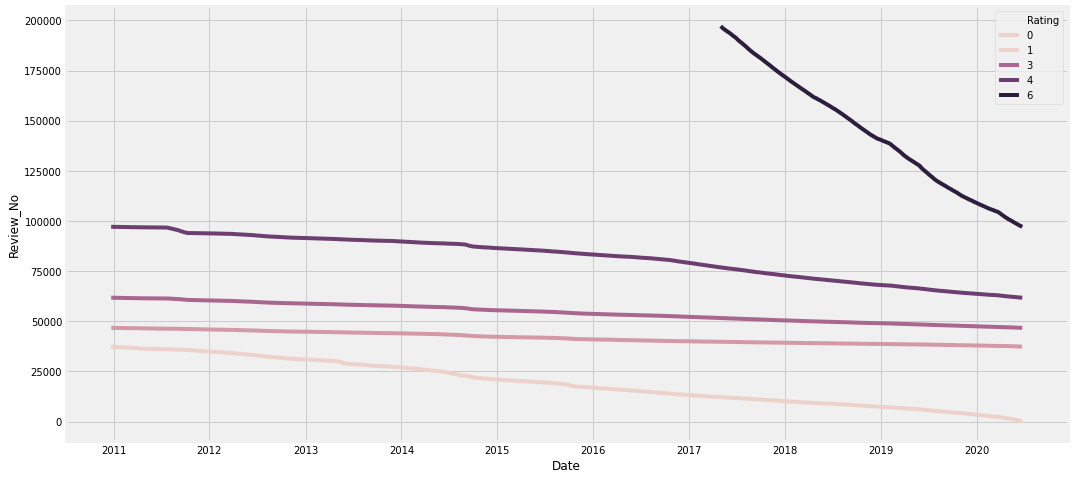

In [35]:
sns.lineplot(x = 'Date', y = 'Review_No', hue = 'Rating', data=df_dominant_topic)

In [36]:
df_dominant_topic[df_dominant_topic['Rating']==5]['Date'].min()

Timestamp('2017-04-30 19:55:57')

We only have 5 star ratings beginning April 30th, 2017. Thus, let's focus on ads from that day onwards.

In [37]:
df_final = df_dominant_topic[df_dominant_topic['Date']>'2017-04-30 00:00:00']

In [39]:
df.shape

(196843, 10)

In [38]:
df_final.shape

(134665, 8)

In [27]:
df_final['Rating'].value_counts(normalize=True)

5    0.742472
4    0.112397
1    0.090662
3    0.036453
2    0.018015
Name: Rating, dtype: float64

Majority (74%) of the reviews past 2017-04-30 are rated 5 stars.

In [28]:
df_dom_topic_rating_final = df_final.groupby(['Dominant_Topic', 'Rating'])['Review_No'].count().reset_index().pivot_table('Review_No', ['Dominant_Topic'], 'Rating')

In [29]:
df_dom_topic_rating_final

Rating,1,2,3,4,5
Dominant_Topic,,,,,
0.0,1635,332,1183,4738,33523
1.0,222,58,211,1314,16017
2.0,253,57,293,1449,10889
3.0,242,52,228,1176,9510
4.0,778,160,235,493,1991
5.0,674,125,233,594,2900
6.0,1812,344,496,719,2815
7.0,1518,190,296,677,3047
8.0,565,183,317,698,1857


In [30]:
df_dominant_topics_dist_final = df_final[['Dominant_Topic', 'Keywords']].groupby(['Dominant_Topic', 'Keywords'])['Keywords'].count().reset_index(name='Num_Reviews')

df_dominant_topics_dist_final['Perc_Reviews'] = ((df_dominant_topics_dist_final['Num_Reviews'])/(df_dominant_topics_dist_final['Num_Reviews'].sum()))*100

df_dominant_topics_dist_final['Dominant_Topic'] = df_dominant_topics_dist_final['Dominant_Topic'] + 1

df_dominant_topics_dist_final['1_Star'] = df_dom_topic_rating_final.iloc[:,:1]
df_dominant_topics_dist_final['2_Star'] = df_dom_topic_rating_final.iloc[:,1:2]
df_dominant_topics_dist_final['3_Star'] = df_dom_topic_rating_final.iloc[:,2:3]
df_dominant_topics_dist_final['4_Star'] = df_dom_topic_rating_final.iloc[:,3:4]
df_dominant_topics_dist_final['5_Star'] = df_dom_topic_rating_final.iloc[:,4:5]

In [31]:
df_dominant_topics_dist_final

,Dominant_Topic,Keywords,Num_Reviews,Perc_Reviews,1_Star,2_Star,3_Star,4_Star,5_Star
0,1.0,"fun, great, lot, play, easy, addictive, fast, wonderful, mind, simple",41411,30.809005,1635,332,1183,4738,33523
1,2.0,"game, love, nice, awesome, good, amazing, force, close, challenge, reward",17822,13.259233,222,58,211,1314,16017
2,3.0,"good, game, poker, world, job, market, favourite, solid, beautiful, excited",12941,9.627861,253,57,293,1449,10889
3,4.0,"good, game, poker, fantastic, online, store, line, gambling, music, superb",11208,8.338541,242,52,228,1176,9510
4,5.0,"app, day, star, notification, gift, annoying, hour, phone, uninstalled, uninstall",3657,2.720739,778,160,235,493,1991
5,6.0,"time, game, update, app, screen, work, freeze, long, load, open",4526,3.367259,674,125,233,594,2900
6,7.0,"chip, free, account, spin, bonus, amount, buy, coin, gold, purchase",6186,4.602268,1812,344,496,719,2815
7,8.0,"player, bad, year, playing, guy, stupid, level, experience, crap, download",5728,4.261524,1518,190,296,677,3047
8,9.0,"table, play, friend, option, big, alot, buddy, change, facebook, thing",3620,2.693212,565,183,317,698,1857
9,10.0,"problem, fix, connection, version, phone, issue, update, error, bug, log",2598,1.932863,674,219,273,384,1048


This is the topic distribution we will be focusing on with reviews after Apr. 30, 2017.

In [393]:
df_dominant_topics_dist.to_csv('topic_dist_final.csv', index=False)

In [56]:
df_final['Rating'].value_counts(normalize=True)

5    0.742472
4    0.112397
1    0.090662
3    0.036453
2    0.018015
Name: Rating, dtype: float64

85% of all reviews are rated 4-5 Stars.

In [33]:
df_final[(df_final['Dominant_Topic']==0)]['Rating'].value_counts(normalize=True)

5    0.809519
4    0.114414
1    0.039482
3    0.028567
2    0.008017
Name: Rating, dtype: float64

In [34]:
df_final[(df_final['Dominant_Topic']==9) & (df_final['Rating']==1) ][['Text','Rating','Date']].sample(5)

,Text,Rating,Date
11663,Connection lost,1,2017-07-09 05:56:42
10845,It's a rip off you buy chips it takes your money then will not let you back on it freezes up then tells you there is a connection problems but it's not they will rip you off,1,2017-10-11 03:35:08
650,Very slow,1,2020-06-05 10:15:28
7759,CHIPS DISAPPEAR WITH LATEST VERSION UPDATE. EVERYTIME I SWITCH TO A NEW TABLE I SHOULD HAVE MORE THAN WHAT I DID BUT INSTEAD I HAVE LESS. HORRIBLE FIX THE PROBLEM,1,2018-11-13 14:23:22
7606,", this game cannot install on my mobile honour C7 what's the problem please guide me",1,2018-11-30 08:51:37


In [36]:
df_final[(df_final['Dominant_Topic']==9) & (df_final['Rating']==5) ][['Text','Rating','Date']].sample(5)

,Text,Rating,Date
176437,Great game thanks,5,2017-11-12 03:21:17
161931,Ok,5,2018-04-14 16:17:15
193319,This game is great I enjoy everything about it!!!!!,5,2017-06-05 02:33:41
112016,Judi itu haram,5,2019-11-08 17:37:46
193940,Woowww,5,2017-05-28 22:44:15


In [37]:
df_dominant_topics_dist_final

,Dominant_Topic,Keywords,Num_Reviews,Perc_Reviews,1_Star,2_Star,3_Star,4_Star,5_Star
0,1.0,"fun, great, lot, play, easy, addictive, fast, wonderful, mind, simple",41411,30.809005,1635,332,1183,4738,33523
1,2.0,"game, love, nice, awesome, good, amazing, force, close, challenge, reward",17822,13.259233,222,58,211,1314,16017
2,3.0,"good, game, poker, world, job, market, favourite, solid, beautiful, excited",12941,9.627861,253,57,293,1449,10889
3,4.0,"good, game, poker, fantastic, online, store, line, gambling, music, superb",11208,8.338541,242,52,228,1176,9510
4,5.0,"app, day, star, notification, gift, annoying, hour, phone, uninstalled, uninstall",3657,2.720739,778,160,235,493,1991
5,6.0,"time, game, update, app, screen, work, freeze, long, load, open",4526,3.367259,674,125,233,594,2900
6,7.0,"chip, free, account, spin, bonus, amount, buy, coin, gold, purchase",6186,4.602268,1812,344,496,719,2815
7,8.0,"player, bad, year, playing, guy, stupid, level, experience, crap, download",5728,4.261524,1518,190,296,677,3047
8,9.0,"table, play, friend, option, big, alot, buddy, change, facebook, thing",3620,2.693212,565,183,317,698,1857
9,10.0,"problem, fix, connection, version, phone, issue, update, error, bug, log",2598,1.932863,674,219,273,384,1048


In [39]:
df['at'] = pd.to_datetime(df['at'])

In [40]:
df_may = df[df['at']>'2017-04-30 00:00:00']

In [41]:
df_may[df_may['thumbsUpCount']>=100]['score'].value_counts(normalize=True)

1    0.512077
5    0.227053
4    0.096618
3    0.086957
2    0.077295
Name: score, dtype: float64

Very interesting that the majority of reviews with 100 thumbs up or more are rated 1 Star (54.7%).

In [42]:
df_may_dom = df_dominant_topic[df_dominant_topic['Date']>'2017-04-30 00:00:00']

In [44]:
df_may_dom['thumbs'] = df_may['thumbsUpCount']

In [45]:
df_may_dom['Dominant_Topic'] = df_may_dom['Dominant_Topic'] + 1

In [578]:
df_may_dom.sort_values(by='thumbs', ascending=False).head(20)

,Review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Rating,Version,Date,thumbs
51496,51596,1.0,0.0714,"fun, great, lot, play, easy, addictive, fast, wonderful, mind, simple",Love the game...but it is SO UNFAIR that people with higher rank on there get better hands and take everyones money. Its not FAIR at all that you have it RIGGED to give them the winning hand! I bought so many coins. I dont think I will be buying anymore. Your game does not play fair. The cards should be delt out like we play in real life with NO GLITCHES OR CHEATS!!! I SAY YOU OWE ME SOME COINS ZYNGA!,3,21.28,2017-05-02 23:43:59,1168
51009,51107,14.0,0.1429,"money, people, real, site, fair, bot, loose, bad, lose, life",I enjoy playing however i dont enjoy losing every hand. I get a really good hand like a full house and someone always has a higher one. My mother in law plays and wins nearly every hand. But it seems that every hand i get i cant win because someone always has better. It seems like the game is rigged. Ive lost 6 times tonight because someone has had a higher fullhouse or they have had a better 3 of a kind. I can be a good sport for a couple. But 6 times in a half hour is a bit extreme.,3,21.33,2017-08-09 12:20:28,993
66635,66780,6.0,0.0831,"time, game, update, app, screen, work, freeze, long, load, open",I love the game. I do have a suggestion I think you should add a i bluffed button in the table chat it already gives the option for other poker to be mean with the tissue. I think adding that the person Bluff that hand will make the game a little interesting next time they would play somebody. this is a game where either you have it or you don't I know some other games have where you can show your cards you don't have to do that but adding adding you bluffed in the table would be cool,4,21.68,2019-04-16 16:44:02,921
5746,5746,14.0,0.1467,"money, people, real, site, fair, bot, loose, bad, lose, life","really bad mechanics. this game by zynga will make you loose your mind. you won't understand what's going on. you will loose everything and they hope you will buy new chips with real cash but don't. this game has been made to be frustrating and a money maker. if you like poker and wants to play with serious players, find something else than this.",1,21.75,2019-06-21 18:13:56,710
157934,158175,4.0,0.0836,"good, game, poker, fantastic, online, store, line, gambling, music, superb","Personally, I way prefer this app over other Texas Holdem apps. I LOVE the \ngraphics and with the latest updates the game is user friendly compared to \nother games I've played. I like the league system too! One thing I must say \nI wish was Improved on,, I feel there should be more ways to get trophies \nand unique items. I miss the permanent items that existed in past versions \nof the game. I also bought a lot of permanent items with gold on the Pc \nFacebook version which I have no access too, since the latest update (which \nI like, just miss my items lol) These items were really cool. (Pigzy and a \nMonkey character) I liked the fact that you could also do a lot more with \ngold in the online shop to buy items. Other than that I really recommend \nZynga poker!",5,21.53,2018-06-09 06:42:17,697
6818,6818,5.0,0.1289,"app, day, star, notification, gift, annoying, hour, phone, uninstalled, uninstall","best thing to uninstall!!!! all are bot... your playing annoying bot! never give you chamce to win!!! wasting time it gives almost 5-10 rounds to have 1 winning cards!!! cheating app.... DAMAGE BATTERY, THOUGHTS, AND TIME!!!! YOU CANT WIN THIS GAME ITS ALL ABOUT CHEATING GAME WITH ALL BOT... they know your cards!!!!! all accounts that won the LIVE ARE ALL BOT!!!! SELF DESTRUCTION! YOU CANT DO OTHER THINGS WITH THIS GAME.. IN THE END YOU NEVER WIN... All LIES...... NO SUCH THING!!",1,21.67,2019-03-09 21:12:25,696
127617,127857,13.0,0.0809,"game, great, nice, cool, excellent, graphic, ad, love, addictive, enjoyable",I absolutely love this game. I have noticed some gl

In [577]:
df_may_dom.to_csv('df_may_dom.csv', index=False)

### Top 3 Liked Reviews by Topic & Rating

In [31]:
df_may_dom = pd.read_csv('df_may_dom.csv')

In [70]:
df_may_dom['Date'] = pd.to_datetime(df_may_dom['Date'])

In [33]:
df_may_dom.sort_values(['Dominant_Topic','Rating','thumbs'],ascending=False).groupby(['Dominant_Topic','Rating']).head(3)

,Review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Rating,Version,Date,thumbs
43388,105805,14.0,0.0821,"money, people, real, site, fair, bot, loose, bad, lose, life","absolutely love this game. so very addictive and I love being able to play Iive. unfortunately the only down fall is the rude men who say disgusting things to women. I like the mute button for that... I would recommend this game to anyone. Love, love, love,the competition. Love the game I love the upgrades and extra gifts... I've been playing for years now.. still my favorite go to game... thanks Zynga :)",5,21.86,2020-02-24 05:42:36,480
43591,106008,14.0,0.1496,"money, people, real, site, fair, bot, loose, bad, lose, life","An exciting,fun and wholesome game,I am so glad that the racism,bots and bad manners have been cleaned up, now its really fun to play...Good Job !!! I don't think you can improve this game, because you can't get past gouging for money, it is udicrous having a free game but costs a small fortune to play it and if course if you give a bad review....you lose every hand , paid chips or free chips, no matter. I am very disgruntled so I resign.",5,21.86,2020-02-19 14:32:31,101
45841,108258,14.0,0.0944,"money, people, real, site, fair, bot, loose, bad, lose, life","Ever since they started with these pop-ups this game has become unplayable. These pop-ups happen when you leave a table to go to the lobby, they happened when you enter Zynga game itself, every time you change a screen you get a pop up. And it's very big brotherish. They know every website I've been to because the pop-ups are things I've ordered online or I've looked at. There are better games out there now that these pop-ups have appeared",5,21.85,2020-01-12 03:36:39,62
25050,67240,14.0,0.1050,"money, people, real, site, fair, bot, loose, bad, lose, life","5th review. Every few days I am ask if I would like to leave a review getting 1st review Five stars is a rating, it could have been 4 stars but I chose the 5. sometimes I really dislike rating games and apps but what the hell. So here I am rating this one so hopefully it will quit asking me to rate. The Zynga App is decent, really decent. I've never been to Florida but if I ever go I will definitely bring my personal cell phone with this app still installed. Not if I drive but like if I fly, yes",4,21.67,2019-03-14 22:03:17,603
34574,76764,14.0,0.0879,"money, people, real, site, fair, bot, loose, bad, lose, life","Haven't played many sites for Hold 'em, but this one is pretty consistent to me. You have the ""all in"" players like all other sites, but this one doesn't seem to reward them too often. Fun way to pass time....just remember it is fake money, have fun!",4,21.28,2017-05-04 21:59:06,95
24853,67043,14.0,0.1013,"money, people, real, site, fair, bot, loose, bad, lose, life","One of my favourite gameplay application, but I am really not happy. The \nreason for my hatred is that zynga poker just duped me. In a sale it was \noffering 506 million chips for 667 rupees but when I purchased it, I only \nreceived 84 million chips. I tried contacting them but haven't received any \nhelp so far.",4,21.67,2019-03-27 08:10:07,34
19048,51107,14.0,0.1429,"money, people, real, site, fair, bot, loose, bad, lose, life",I enjoy playing however i dont enjoy losing every hand. I get a really good hand like a full house and someone always has a higher one. My mother in law plays and wins nearly every hand. But it seems that every hand i get i cant win because someone always has better. It seems like the game is rigged. Ive lost 6 times tonight because someone has had a higher fullhouse or they have had a better 3 of a kind. I can be a good sport for a couple. But 6 times in a half hour is a bit extreme.,3,21.33,2017-08-09 12:20:28,993
17918,49977,14.0,0.1544,"money, people, real, site, fair, bot, loose, bad, lose, life","It is a fun and easily addictive game (but in the good way). The only problem I have is I cannot find friends that play this

### # of Reviews by Rating per Day

In [46]:
df_may_dom['Date'] = df_may_dom['Date'].dt.date

In [47]:
df_may_dom['Date'] = pd.to_datetime(df_may_dom['Date'])

In [48]:
table_1 = df_may_dom.groupby(['Date','Rating'])['Review_No'].count().reset_index()

In [49]:
table_1.head()

,Date,Rating,Review_No
0,2017-04-30,1,5
1,2017-04-30,2,1
2,2017-04-30,3,3
3,2017-04-30,4,16
4,2017-04-30,5,24


In [613]:
# date is from 2017-04-30 to 2020-06-22
table_1.to_csv('table_1.csv', index=False)

In [50]:
table_1_sum = table_1.groupby('Date')['Review_No'].sum().reset_index()

In [51]:
table_1_perc = table_1.merge(table_1_sum,on='Date',how='outer')

In [52]:
table_1_perc['Perc'] = table_1_perc['Review_No_x'] / table_1_perc['Review_No_y']

In [664]:
# date is from 2017-04-30 to 2020-06-22
table_1_perc.to_csv('table_1_perc.csv', index=False)

In [53]:
table_1_perc.head()

,Date,Rating,Review_No_x,Review_No_y,Perc
0,2017-04-30,1,5,49,0.102041
1,2017-04-30,2,1,49,0.020408
2,2017-04-30,3,3,49,0.061224
3,2017-04-30,4,16,49,0.326531
4,2017-04-30,5,24,49,0.489796


### Dominant Topic Reviews Rated 1 Star after Q2 2019

In [81]:
df_may_dom[(df_may_dom['Date']>='2019-07-1 00:00:00') & (df_may_dom['Rating']==1)]['Dominant_Topic'].value_counts(normalize=True)

7.0     0.146598
8.0     0.128251
1.0     0.121482
14.0    0.119166
11.0    0.116851
5.0     0.068222
6.0     0.059672
9.0     0.055932
10.0    0.050410
12.0    0.037763
13.0    0.032419
3.0     0.025650
4.0     0.020306
2.0     0.017278
Name: Dominant_Topic, dtype: float64

In [80]:
df_may_dom[(df_may_dom['Date']>='2019-07-1 00:00:00') & (df_may_dom['Rating']==1)]['Dominant_Topic'].value_counts(normalize=True).head(5).sum()

0.6323477021731386

63% of 1 star reviews after Q2 2019 belong to topics 1,7,8,11,14.

In [83]:
df_may_dom[(df_may_dom['Date']>='2019-07-1 00:00:00') & (df_may_dom['Rating']==1)].shape

(5614, 9)

In [87]:
df_may_dom[(df_may_dom['Date']>='2019-07-1 00:00:00') & (df_may_dom['Rating']==1)].sort_values('thumbs', ascending=False).head(20)

,Review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Rating,Version,Date,thumbs
778,778,14.0,0.1484,"money, people, real, site, fair, bot, loose, bad, lose, life","Genuine review..very poor site..challenged zynga on their claim of fair play "" they came up short"" many bots, very rigged EG..flushes.straights..full houses are like pairs in a real game.The more chips you have, the odds of you winning go down..Think of the most rigged poker site you can..then double it to get zynga.Fair play .NO..so certified by whom.I have proven the site rigged so i will give away my chips soon",1,21.94,2020-05-31 13:42:30,599
2467,2467,1.0,0.0714,"fun, great, lot, play, easy, addictive, fast, wonderful, mind, simple",Go to hell bunch of mf!! You're a joke!! Zynga bingo!! Go back to where you belong!!,1,21.88,2020-03-15 02:08:02,513
5229,5229,14.0,0.1348,"money, people, real, site, fair, bot, loose, bad, lose, life","I have played almost 100,000 hands and it's the same story. Horrible customer service, no resolution to in game cheaters and hackers, and obvious collusion with other player cheat groups. Do not waste your time or money on this game. I will not change my rating till the issues are fixed. Zynga doesn't care about people getting screwed out of their money. It is built into their algorithms to get you to spend. They allow these scammers to thrive. F U ZYNGA.",1,21.78,2019-07-31 20:22:15,498
4736,4736,14.0,0.1261,"money, people, real, site, fair, bot, loose, bad, lose, life",horrible. the creators of this game seriously need to get the BOT situation under control. Explain to me how a pair of 4s beats a 3 of a kind aces? reporting bots or people cheating does nothing. zynga does nothing about it. I use to enjoy this game but now it's nothing other then a cheating ground for zynga bots.. people out there. don't ever spend your money on chips. they just get stolen. Plus Zynga also steals from your chip account.. i had over 1 billion one day and the next they all gone,1,21.80,2019-09-13 17:39:57,388
607,607,11.0,0.1279,"hand, card, win, high, full, pair, bet, pot, big, low","Please don't waste your time. Will freeze up mid hand on the screen and keep you in the hand, ""table rake"" steals the pot. And it'll lock you in the next hand because of all the pop up bs. You can't exit after your loss. You can't navigate anything. It automatically pops up responses. I can't begin to tell you how bad this app has gotten. Oh yeah and now they have pop up adds as bad as any other.",1,21.94,2020-06-06 22:37:49,367
686,686,7.0,0.1202,"chip, free, account, spin, bonus, amount, buy, coin, gold, purchase","Constantly stopping - costing me & i'm sure, others thousands of dollars!!! No explanation & no chance to recover lost $$$ Just keeps on going as though nothing has happened. I just now got out for not a single game went by without interruptions. BTW, I have never been able to recover millions I lost when I got disgusted & signed off. I just recently started playing again under different name for I could not recover money I won using the Accordian Symbol. I am again quitting Zynga till it gets F",1,21.94,2020-06-03 19:34:43,334
4276,4276,11.0,0.1774,"hand, card, win, high, full, pair, bet, pot, big, low","Can't prove but the game feels rigged to me. Go onto people's profiles and everyone has at least a straight flush or better. That stuff is so rare...I can't BELIEVE how many quads, straights, full houses, and flushes come up all the time!!!!! It's incredibly unrealistic and crazy, I guess they have to make it interesting for people. There's some sort of computer algorithm that's manipulating things and they're taking advantage of people...good luck, I'm done with this app.",1,21.82,2019-10-28 13:37:57,321
802,802,14.0,0.1183,"money, people, real, site, fair, bot, loose, bad, lose, life",Just like all online poker apps this app uses mindless betting BOTS to try and stimulate pot growth so app can script deal the board and rob you off all your chips

## Summary

Topics 1,2,3,4,9,13 have reviews expressing their love for Zynga Poker.

Highlights:
- There are many rewarding challenges
- The game has improved greatly over the years
- Very addictive game and great time killer with beautiful graphics

Topics 7,8,11,12,14 have pessimistic reviews.

Highlights:
- Losing because game is rigged
- Buying more chips make you lose more
- Bad players always go all in (i.e., Bingo player)

Topics 5,6,10 focus on the game's bugs, fixes, and enhancements
- Free chip ads and free spins not working properly
- Too many annoying ads
- Event updates cause blank screens